In [152]:
# Dependencies (Note: This workbook must be run on a Python version that supports pymc due to the deprecation of distutils. Created using version 3.11.)
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy.stats import beta
import pymc as pm
import numpy as np
import seaborn as sns

In [121]:
# Load datasets and create SQLite DB
seager_hits = pd.read_csv('SeagerHits.csv')
rangers_schedule = pd.read_csv('Rangers2025Schedule.csv')

connection = sqlite3.connect('seager.db')

seager_hits.to_sql('seager_hits', connection, index=False, if_exists='replace')

488

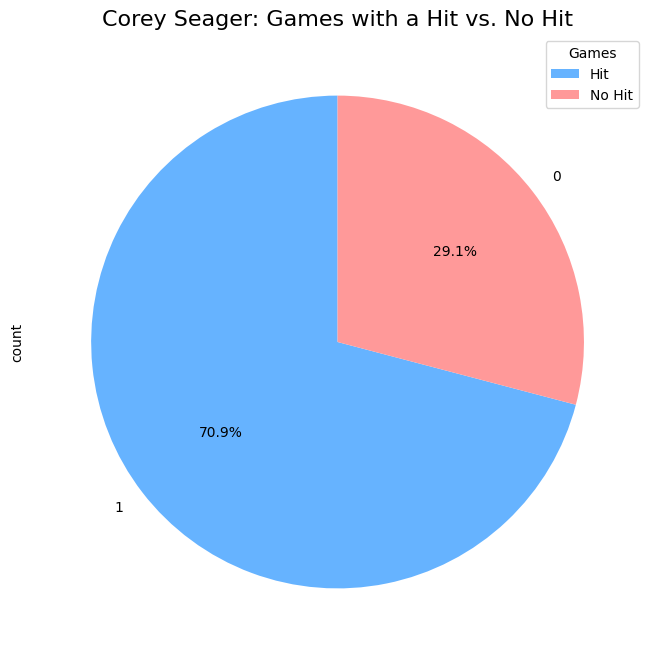

In [154]:
# Plot distribution of games with hit vs. no hit
hit_distribution = seager_hits['Got_Hit'].value_counts()
plt.figure(figsize=(8, 8))
hit_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Corey Seager: Games with a Hit vs. No Hit', fontsize=16)
plt.legend(title='Games', labels=['Hit', 'No Hit'], loc='upper right')
plt.savefig("HitvsNoHit.png")
plt.show()

In [123]:
# Query for opponent distributions 
opp_query = """
SELECT Opp AS Opponent,
    CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Alpha,
    CAST(SUM(CASE WHEN H = 0 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Beta,
    ROUND(CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS FLOAT) / CAST(COUNT(*)+2 AS FLOAT),4) AS Opp_Prob
FROM seager_hits
WHERE Opp IS NOT NULL
GROUP BY Opp
ORDER BY Opp_Prob DESC;
"""

opp_df = pd.read_sql_query(opp_query, connection)
opp_df

,Opponent,Alpha,Beta,Opp_Prob
0,TOR,17,1,0.9444
1,MIL,12,2,0.8571
2,CHC,8,2,0.8000
3,ARI,12,3,0.8000
4,COL,19,5,0.7917
5,PHI,11,3,0.7857
6,MIN,17,5,0.7727
7,LAA,30,9,0.7692
8,LAD,3,1,0.7500
9,KCR,12,4,0.7500


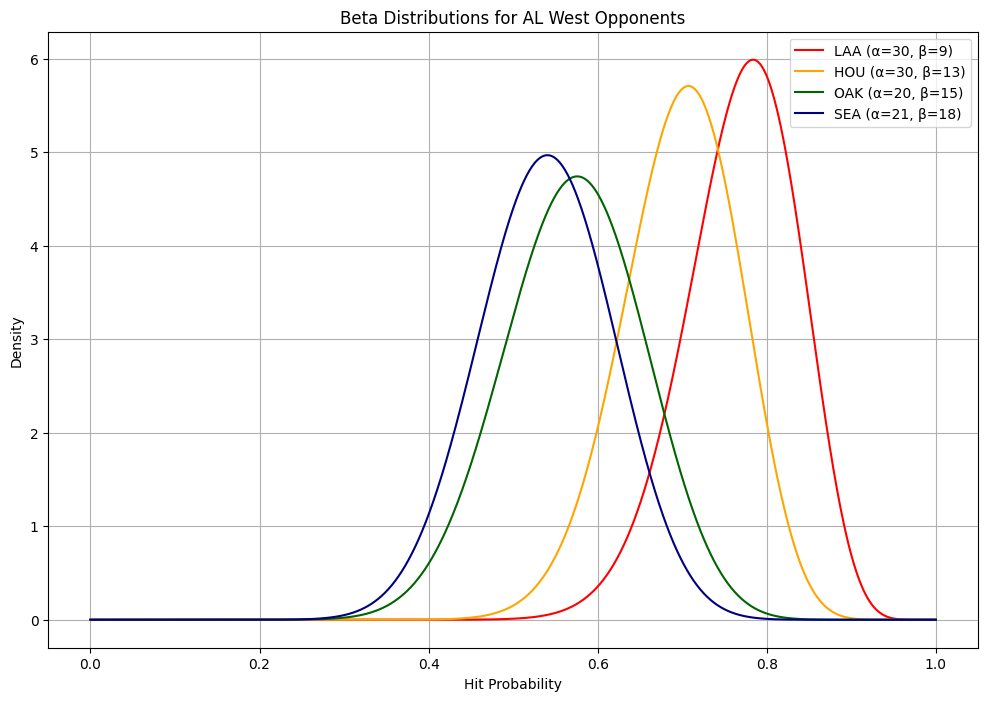

In [155]:
# Plot Beta distributions for AL West opponents
division_opp = ['LAA', 'HOU', 'SEA', 'OAK']
division_opp_df = opp_df[opp_df['Opponent'].isin(division_opp)]

color_map = {
    'LAA': 'red',
    'HOU': 'orange',
    'SEA': 'navy',
    'OAK': 'darkgreen'
}

x = np.linspace(0, 1, 1000)

plt.figure(figsize=(12, 8))
for index, row in division_opp_df.iterrows():
    alpha, beta_param = row['Alpha'], row['Beta']
    pdf_values = beta.pdf(x, alpha, beta_param)
    opponent = row['Opponent']
    color = color_map.get(opponent, 'black')  # Default color if not in the map
    plt.plot(x, pdf_values, label=f"{opponent} (α={alpha}, β={beta_param})", color=color)

plt.title('Beta Distributions for AL West Opponents')
plt.xlabel('Hit Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("OppBetaDist.png")
plt.show()

In [125]:
# Query for month distributions 
month_query = """
SELECT strftime('%m', DATETIME(Date)) AS Month,
    CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Alpha,
    CAST(SUM(CASE WHEN H = 0 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Beta,
    ROUND(CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS FLOAT) / CAST(COUNT(*)+2 AS FLOAT),4) AS Month_Prob
FROM seager_hits
WHERE Opp IS NOT NULL
GROUP BY Month
ORDER BY Month;
"""

month_df = pd.read_sql_query(month_query, connection)
month_df

,Month,Alpha,Beta,Month_Prob
0,03,4,1,0.8000
1,04,52,30,0.6341
2,05,56,23,0.7089
3,06,52,21,0.7123
4,07,50,17,0.7463
5,08,76,30,0.7170
6,09,58,24,0.7073
7,10,6,4,0.6000


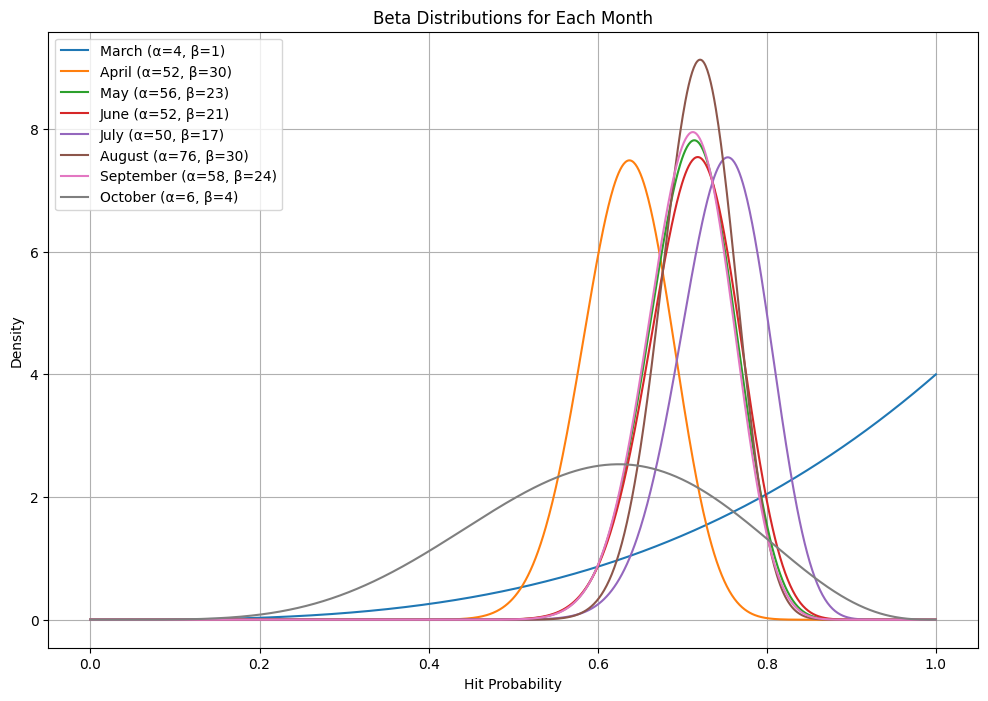

In [156]:
# Plot Beta distributions for each month
month_names = {
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October'
}

x = np.linspace(0, 1, 1000)

plt.figure(figsize=(12, 8))
for index, row in month_df.iterrows():
    alpha, beta_param = row['Alpha'], row['Beta']
    pdf_values = beta.pdf(x, alpha, beta_param)
    month_name = month_names[row['Month']]
    plt.plot(x, pdf_values, label=f"{month_name} (α={alpha}, β={beta_param})")

plt.title('Beta Distributions for Each Month')
plt.xlabel('Hit Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("MonthBetaDist.png")
plt.show()

In [127]:
# Query for home/away distributions
home_away_query = """
SELECT Home_Team as Home_Away,
    CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Alpha,
    CAST(SUM(CASE WHEN H = 0 THEN 1 ELSE 0 END) + 1 AS SIGNED) AS Beta,
    ROUND(CAST(SUM(CASE WHEN H >= 1 THEN 1 ELSE 0 END) + 1 AS FLOAT) / CAST(COUNT(*)+2 AS FLOAT),4) AS Home_Away_Prob
FROM seager_hits
WHERE Opp IS NOT NULL
GROUP BY Home_Team
;
"""

home_away_df = pd.read_sql_query(home_away_query, connection)
home_away_df

,Home_Away,Alpha,Beta,Home_Away_Prob
0,0,178,71,0.7149
1,1,170,73,0.6996


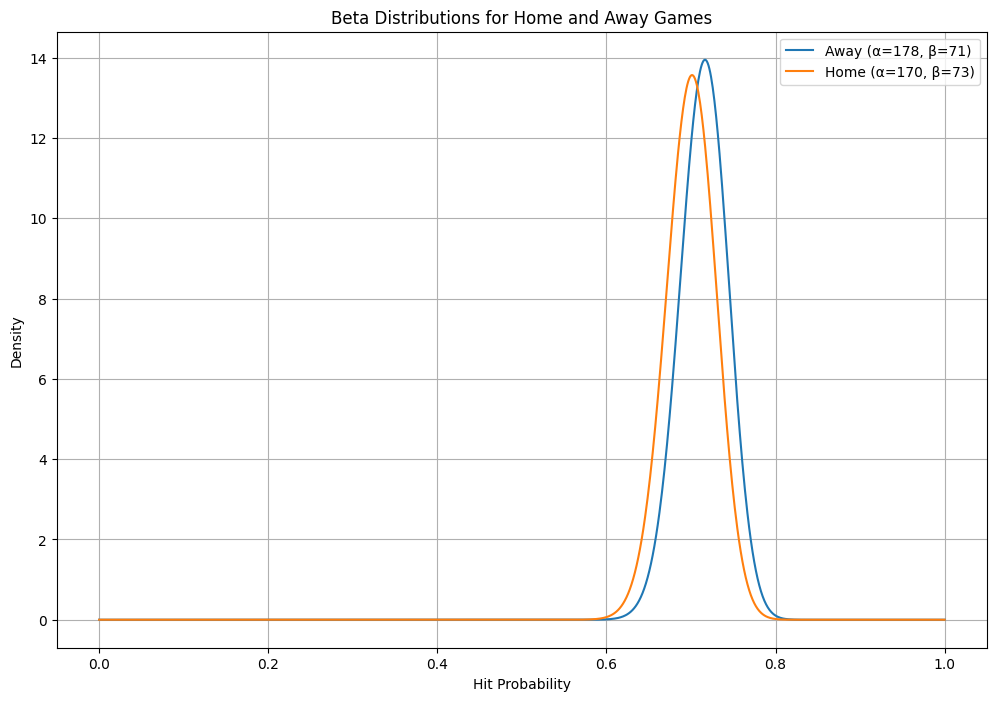

In [157]:
# Plot Beta distributions for home/away
home_away_map = {0: 'Away', 1: 'Home'}

x = np.linspace(0, 1, 1000)

plt.figure(figsize=(12, 8))
for i in range(len(home_away_df['Home_Away'])):
    alpha, beta_param = home_away_df['Alpha'][i], home_away_df['Beta'][i]
    label = home_away_map[home_away_df['Home_Away'][i]]
    pdf_values = beta.pdf(x, alpha, beta_param)
    plt.plot(x, pdf_values, label=f"{label} (α={alpha}, β={beta_param})")

plt.title('Beta Distributions for Home and Away Games')
plt.xlabel('Hit Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.savefig("HABetaDist.png")
plt.show()

In [129]:
# Modify schedule df for grouping
rangers_schedule['Date'] = pd.to_datetime(rangers_schedule['Date'])
rangers_schedule['Month'] = rangers_schedule['Date'].dt.strftime('%m')

In [130]:
# Merge required dataframes
schedule_opp_merged = rangers_schedule.merge(opp_df[['Opponent', 'Alpha', 'Beta']], on='Opponent', how='left').rename(columns={'Alpha': 'Opp_Alpha', 'Beta': 'Opp_Beta'})
opp_month_merged = schedule_opp_merged.merge(month_df[['Month', 'Alpha', 'Beta']], on='Month', how='left').rename(columns={'Alpha': 'Month_Alpha', 'Beta': 'Month_Beta'})
priors_df = opp_month_merged.merge(home_away_df[['Home_Away', 'Alpha', 'Beta']], on='Home_Away', how='left').rename(columns={'Alpha': 'HA_Alpha', 'Beta': 'HA_Beta'})
priors_df.head()

,Date,Opponent,Home_Away,Month,Opp_Alpha,Opp_Beta,Month_Alpha,Month_Beta,HA_Alpha,HA_Beta
0,2025-03-27,BOS,1,03,15,6,4,1,170,73
1,2025-03-28,BOS,1,03,15,6,4,1,170,73
2,2025-03-29,BOS,1,03,15,6,4,1,170,73
3,2025-03-30,BOS,1,03,15,6,4,1,170,73
4,2025-03-31,CIN,0,03,6,4,4,1,178,71


In [131]:
# Define multipliers for home/away
home_multiplier = 1 - 0.0153
away_multiplier = 1 + 0.0153

# Bayesian model
with pm.Model() as model:
    # 1. Opponent-level priors
    opponent_idx = pd.Categorical(priors_df['Opponent']).codes
    opponent_theta = pm.Beta(
        'opponent_theta',
        alpha=priors_df['Opp_Alpha'].groupby(opponent_idx).mean().values,
        beta=priors_df['Opp_Beta'].groupby(opponent_idx).mean().values,
        shape=len(np.unique(opponent_idx))
    )

    # 2. Month-level priors
    month_theta = pm.Beta(
        'month_theta',
        alpha=priors_df['Month_Alpha'].groupby(month_idx).mean().values,
        beta=priors_df['Month_Beta'].groupby(month_idx).mean().values,
        shape=len(np.unique(month_idx))
    )
    
    # 3. Home/Away multiplier
    home_away_idx = priors_df['Home_Away']
    home_away_multiplier = pm.Deterministic(
        'home_away_multiplier',
        pm.math.switch(home_away_idx, home_multiplier, away_multiplier)
    )

    # 4. Weighted combination
    combined_theta = pm.Deterministic(
        'combined_theta',
        pm.math.sigmoid(
            0.7 * pm.math.logit(opponent_theta[opponent_idx]) + 
            0.3 * pm.math.logit(month_theta[month_idx])          
        ) * home_away_multiplier
    )

    # Fit the model
    trace = pm.sample(draws=1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [opponent_theta, month_theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


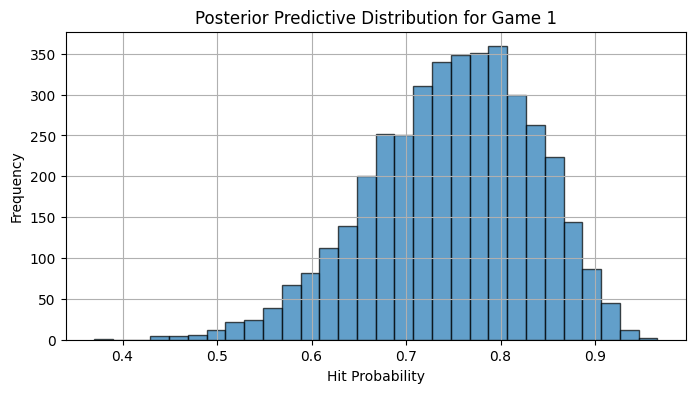

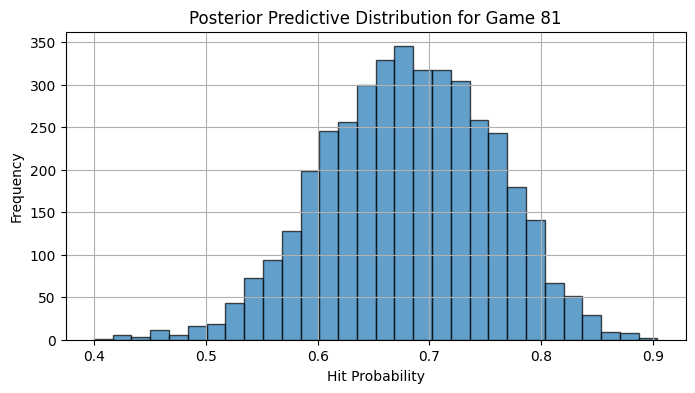

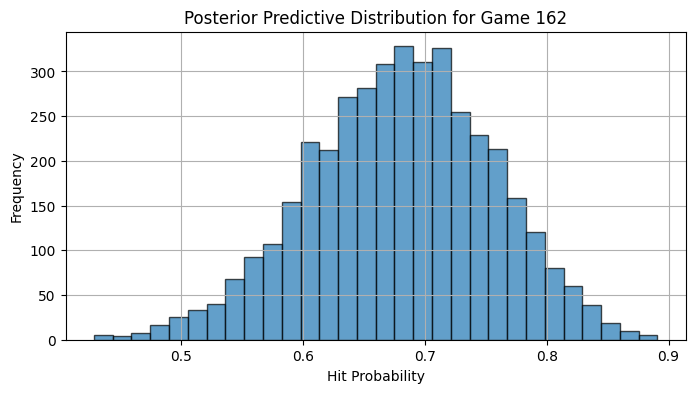

In [158]:
# Store posterior distributions
combined_theta_samples = trace['combined_theta']

# Plot posterior distributions of selected games
selected_games = [0, 80, 161]

for i in selected_games:
    plt.figure(figsize=(8, 4))
    plt.hist(combined_theta_samples[:, i], bins=30, alpha=0.7, edgecolor='k')
    plt.title(f'Posterior Predictive Distribution for Game {i+1}')
    plt.xlabel('Hit Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(f"PPC_Game{i+1}.png")
    plt.show()

In [133]:
# Calculate streak lengths
seager_hits_streak = seager_hits[['Season', 'Date', 'Got_Hit']]

def calculate_streaks(group):
    group['streak_id'] = (group['Got_Hit'] == 0).cumsum()
    streak_lengths = group[group['Got_Hit'] == 1].groupby('streak_id').size()
    
    avg_streak_length = streak_lengths[streak_lengths > 1].mean() if not streak_lengths[streak_lengths > 1].empty else 0
    max_streak_length = streak_lengths.max() if not streak_lengths.empty else 0
    
    return pd.Series({
        'Avg_Streak_Length': avg_streak_length,
        'Max_Streak_Length': max_streak_length
    })

streak_metrics = seager_hits_streak.groupby('Season').apply(calculate_streaks)
streak_metrics

,Avg_Streak_Length,Max_Streak_Length
Season,,
2021,3.111111,5.0
2022,3.538462,10.0
2023,4.400000,10.0
2024,4.500000,16.0


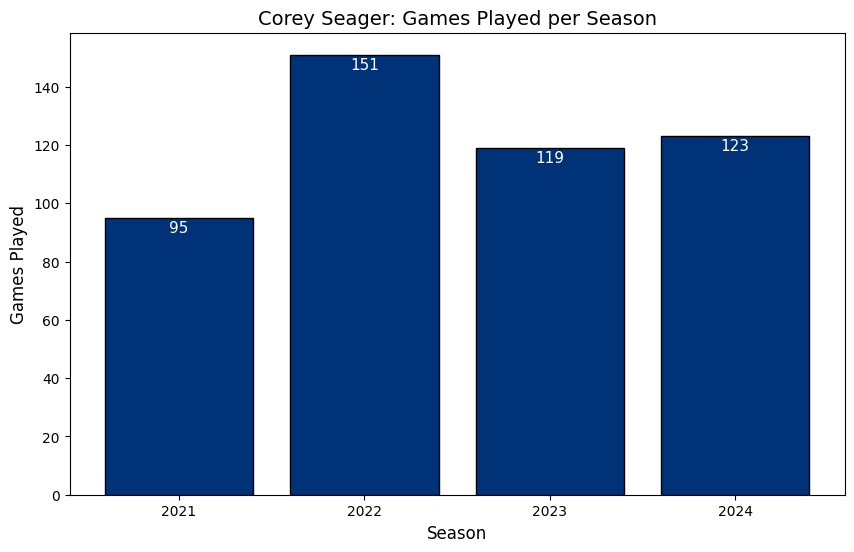

In [159]:
# Plot Seager's games played
games_played = {'Season': ['2021', '2022', '2023', '2024'], 'Games Played': [95, 151, 119, 123]}
plt.figure(figsize=(10, 6))
bars = plt.bar(
    games_played['Season'], 
    games_played['Games Played'], 
    color='#003278', 
    edgecolor='black'
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 5, f'{height}', ha='center', color='white', fontsize=11)

plt.title('Corey Seager: Games Played per Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Games Played', fontsize=12)
plt.savefig("SeagerGP.png")
plt.show()

In [135]:
# Function to adjust hit probs
def adjust_hit_probability(base_prob, current_streak, is_rust_game=False):
    average_streak_length = max(streak_metrics['Avg_Streak_Length'])
    max_streak_length = max(streak_metrics['Max_Streak_Length']) 
    rust_factor = 0.9  # Reduce probability by 10% for rust effect

    if is_rust_game:
        base_prob *= rust_factor
    
    boost = max(0, 1 - abs(current_streak - average_streak_length) / average_streak_length)
    penalty = max(0, (current_streak - max_streak_length) / max_streak_length)
    
    adjusted_prob = base_prob * (1 + 0.025 * boost)
    adjusted_prob *= (1 - 0.05 * penalty)
    
    return min(max(adjusted_prob, 0), 1)

# Function to select DNP games
def select_dnp_games(total_games, num_dnp_sequences=4, sequence_length=10):
    
    dnp_games = set()

    while len(dnp_games) < num_dnp_sequences * sequence_length:
        start = np.random.randint(0, total_games - sequence_length + 1)
        sequence = range(start, start + sequence_length)
        
        # Check if sequence overlaps with existing DNP games
        if not any(game in dnp_games for game in sequence):
            dnp_games.update(sequence)
    
    return dnp_games

# Function to simulate a single Monte Carlo run
def monte_carlo_simulation(trace, n_simulations=1000):
    total_games = trace['combined_theta'].shape[1] 
    longest_streaks = []

    for _ in range(n_simulations):
        current_streak = 0
        longest_streak = 0
        dnp_games = select_dnp_games(total_games)
        next_game_rust = None 

        for game_idx in range(total_games):
            if game_idx in dnp_games: 
                next_game_rust = game_idx + 1 if game_idx + 1 < total_games else None # Mark the next game as a potential rust game
                continue
            
            # Determine if the current game is a rust game
            is_rust_game = game_idx == next_game_rust

            # Sample a probability from the posterior for this game
            base_prob = np.random.choice(trace['combined_theta'][:, game_idx])
            
            # Adjust hit probability based on current streak and rust effect
            adjusted_prob = adjust_hit_probability(base_prob, current_streak, is_rust_game)
            
            # Simulate a hit or miss based on the sampled probability
            hit = np.random.binomial(1, adjusted_prob)

            if hit:
                current_streak += 1
                longest_streak = max(longest_streak, current_streak)
            else:
                current_streak = 0  # Reset streak if no hit

        longest_streaks.append(longest_streak)

    return np.mean(np.array(longest_streaks) >= 20), longest_streaks

# Function to run multiple Monte Carlo simulations
def run_multiple_monte_carlo(trace, num_runs=10, n_simulations_per_run=1000):
    probabilities = []
    all_longest_streaks = []

    for _ in range(num_runs):
        prob_20_game_streak, longest_streaks = monte_carlo_simulation(trace, n_simulations=n_simulations_per_run)
        probabilities.append(prob_20_game_streak)
        all_longest_streaks.extend(longest_streaks)

    median_prob = np.median(probabilities)
    mean_prob = np.mean(probabilities)
    
    print(f"Median Probability of 20-game Hitting Streak: {median_prob:.4f}")
    print(f"Mean Probability of 20-game Hitting Streak: {mean_prob:.4f}")
    
    return probabilities, all_longest_streaks

probabilities, all_longest_streaks = run_multiple_monte_carlo(trace, num_runs=10, n_simulations_per_run=1000)

Median Probability of 20-game Hitting Streak: 0.0305
Mean Probability of 20-game Hitting Streak: 0.0303


In [142]:
import scipy.stats as st
# Monte Carlo probability from simulations
p_estimated = 0.0303  # Example value from Monte Carlo simulation
n_simulations = 10000

# Calculate Standard Error
standard_error = np.sqrt((p_estimated * (1 - p_estimated)) / n_simulations)

# 95% Confidence Interval
z_score = st.norm.ppf(0.975)  # For 95% CI
lower_bound = p_estimated - z_score * standard_error
upper_bound = p_estimated + z_score * standard_error
print(f"95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

95% Confidence Interval: (0.0269, 0.0337)


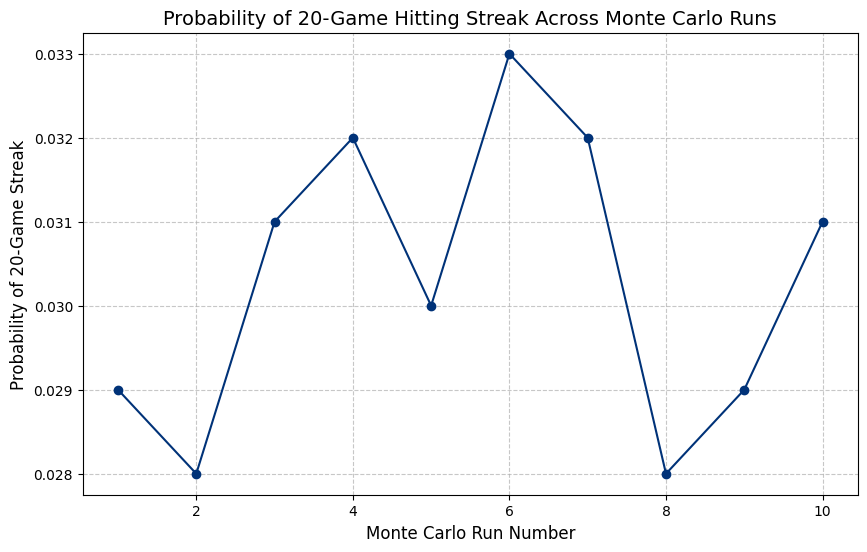

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(probabilities) + 1), probabilities, marker='o', color='#003278')
plt.title('Probability of 20-Game Hitting Streak Across Monte Carlo Runs', fontsize=14)
plt.xlabel('Monte Carlo Run Number', fontsize=12)
plt.ylabel('Probability of 20-Game Streak', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("SeagerGP.png")
plt.show()

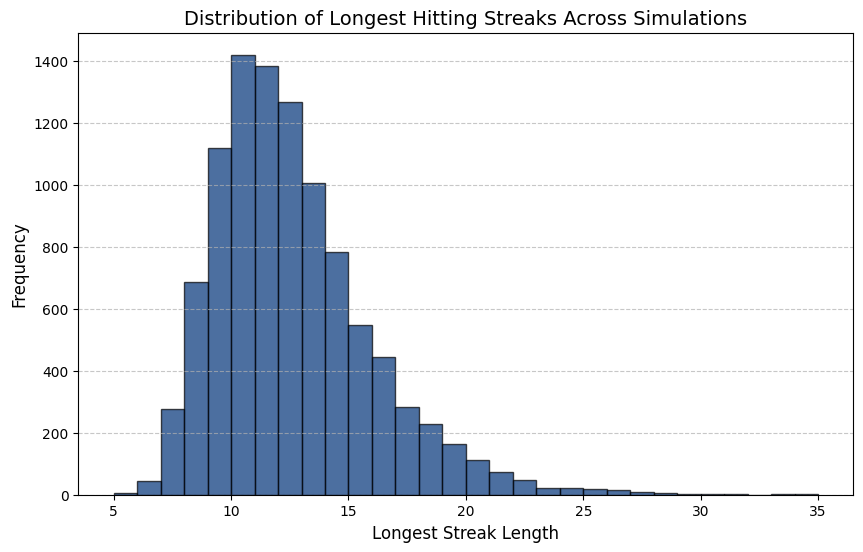

In [136]:
# Plot distribution of longest hitting streaks across sims
plt.figure(figsize=(10, 6))
plt.hist(longest_streaks, bins=30, color='#003278', edgecolor='black', alpha=0.7)
plt.title('Distribution of Longest Hitting Streaks Across Simulations', fontsize=14)
plt.xlabel('Longest Streak Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

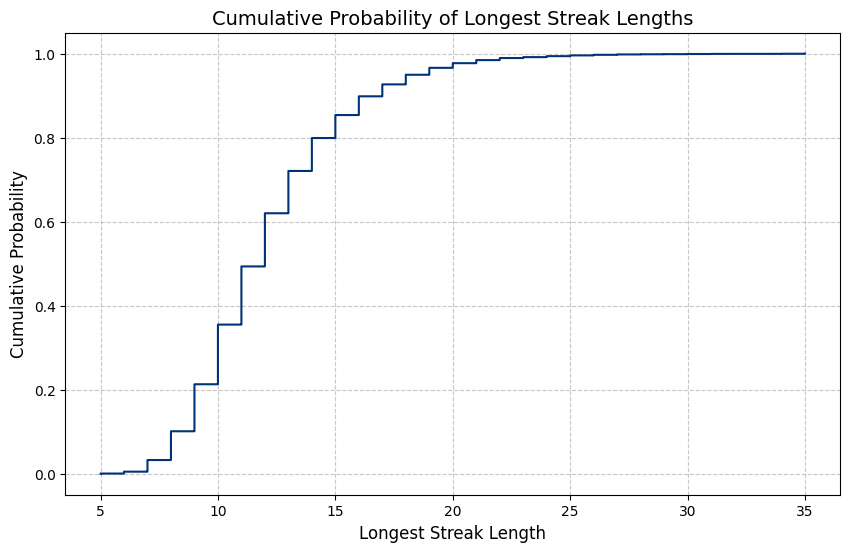

In [137]:
# Plot cumulative prob of longest streak lengths
sorted_streaks = np.sort(longest_streaks)
cdf = np.arange(1, len(sorted_streaks) + 1) / len(sorted_streaks)

plt.figure(figsize=(10, 6))
plt.plot(sorted_streaks, cdf, drawstyle='steps-post', color='#003278')
plt.title('Cumulative Probability of Longest Streak Lengths', fontsize=14)
plt.xlabel('Longest Streak Length', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()